# Deception Detection supported by Machine Learning

## Literature Review - Corpus analysis
This notebook is devoted to performing some analysis on the document corpus rather their content, both before and after screening phases.
The charts and tables found below render a bibliographic profile of the corpus.

Particularly, we explore the rejections after deep screening and present the reasons.
We use **Pandas** and **MatPlotLib**.

### Loading the data from the BiblioAlly Catalog

In [1]:
import BiblioAlly as ally

catalog_path = ".\\"
catalog_file = catalog_path + "DeceptionDetection.db"
catalog = ally.Catalog(catalog_file)

### Retrieving all studies from the Catalog
Documents are all loaded. A subset including only the selected ones is created and a dictionary based on the **id** is setup to
speed up further query operations.

For the selected corpus, metadata already extracted and stored is converted back to Python dictionaries so it can be properly handled.

In [2]:
all_documents = catalog.documents_by()
corpus = [d for d in all_documents if d.is_tagged(ally.TAG_SELECTED)]

document_by_id = dict()
for document in all_documents:
    document_by_id[document.id] = document
metadata = [eval(d.attachment_by_name('Metadata').content) for d in corpus]

### Support code
Supporting functions and structures are provided by the module utility (local file `utility.py`) so the meta-analysis code gets simpler, clearer, and with an uniform behavior.

In [3]:
# MatPlotLib and Pandas setup
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce
import utility

plt.rcParams.update({'font.size': 26})

### Documents statistics
The following chars present general statistics on all the documents somehow related to this effort, not particularly related to the content of
the studies, but with the literature review workflow.

In [4]:
# Creating basic DataFrames either for all documents and the selected corpus as well, so we can perform further analysis
all_documents_dict = ally.as_dict(all_documents,
                                  tags=lambda tags: [t.tag.name for t in tags])
all_documents_df = pd.DataFrame(all_documents_dict, index=all_documents_dict['id'])

corpus_dict = ally.as_dict(corpus)
corpus_df = pd.DataFrame(corpus_dict, index=corpus_dict['id'])

### Articles distribution per source database
Articles were retrieved from four different article databases:
1. ACM Digital Library
2. IEEE Xplore
3. Scopus
4. Web of Science

Here we can see what database most contributed to our initial base of articles, before the selection process.

Those article databases where chosen based on our previous experience on literature reviews on different topics.

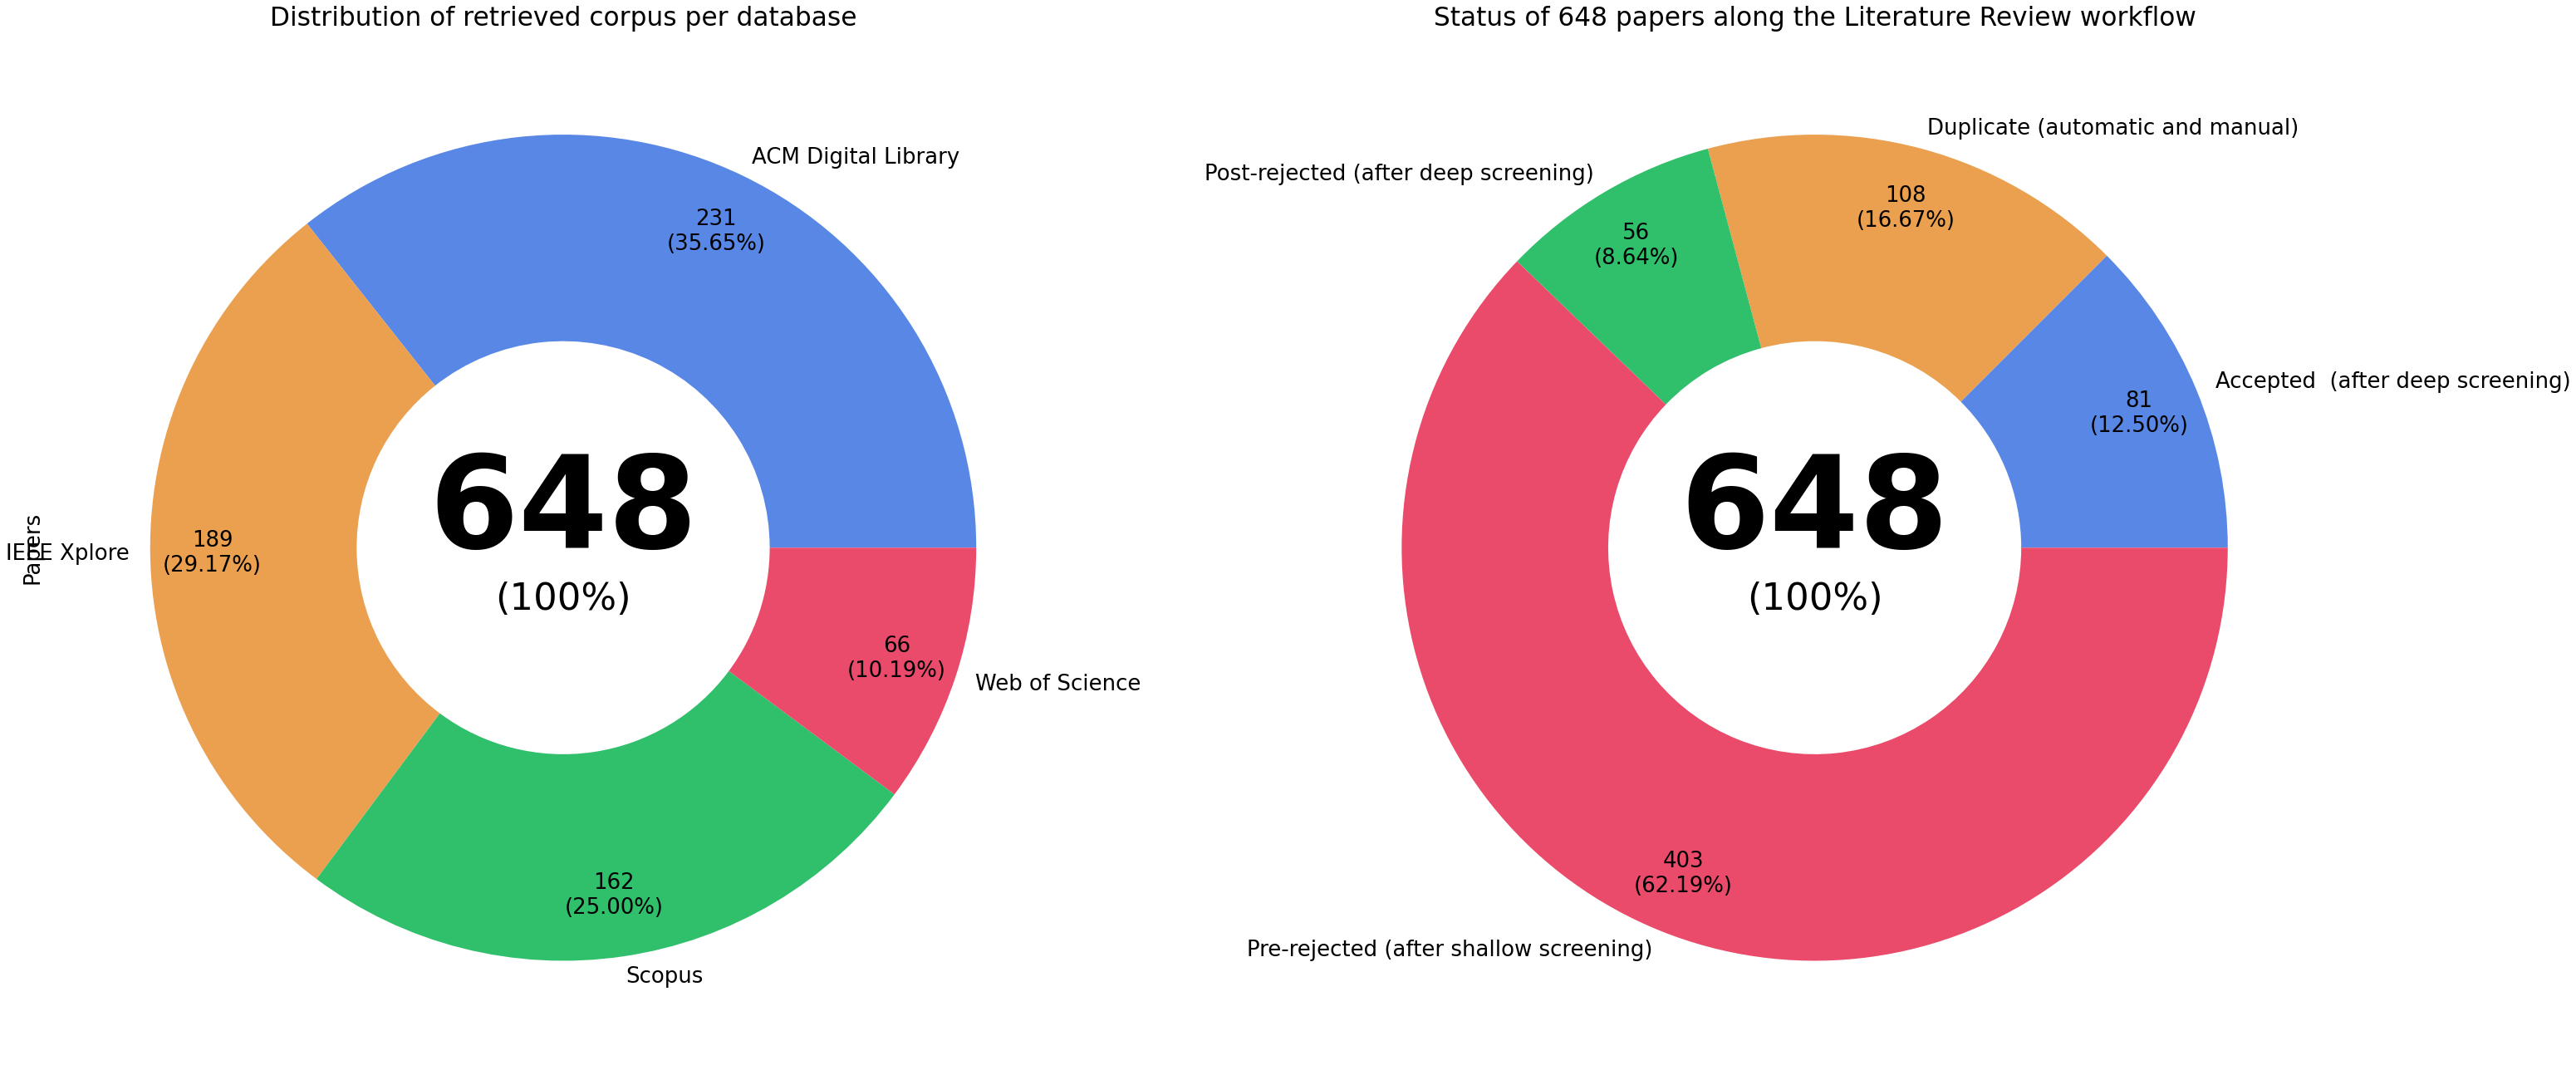

In [5]:
all_source_df = all_documents_df.loc[:,['generator','doi']]
all_source_df = all_source_df.groupby(['generator']).agg(len)
all_source_df.columns = ['Papers']

fig, ax = plt.subplots(1, 2, figsize=(44, 22))
fig.set_tight_layout(0.07)

utility.donut(all_source_df, 'Distribution of retrieved corpus per database', ax=ax[0])

# General statistics
tags_dict = ally.as_dict(all_documents, fields=['id', 'tags'], tags=lambda tags: [t.tag.name for t in tags])
tags_df = pd.DataFrame(tags_dict)
tags_df['Status'] = tags_df.tags.apply(utility.doc_status)
tags_df.drop(columns=['tags'], inplace=True)
tags_df = tags_df.groupby(['Status']).agg(len)

tags_df.columns = ['Document volume by status']
total_papers = tags_df['Document volume by status'].sum()

utility.donut(tags_df, f'Status of {total_papers} papers along the Literature Review workflow', ax=ax[1])
plt.show()

### Rejection reasons
Papers were rejected by a number of different reasons (both before and after the deep screening) and their frequencies are reported below.

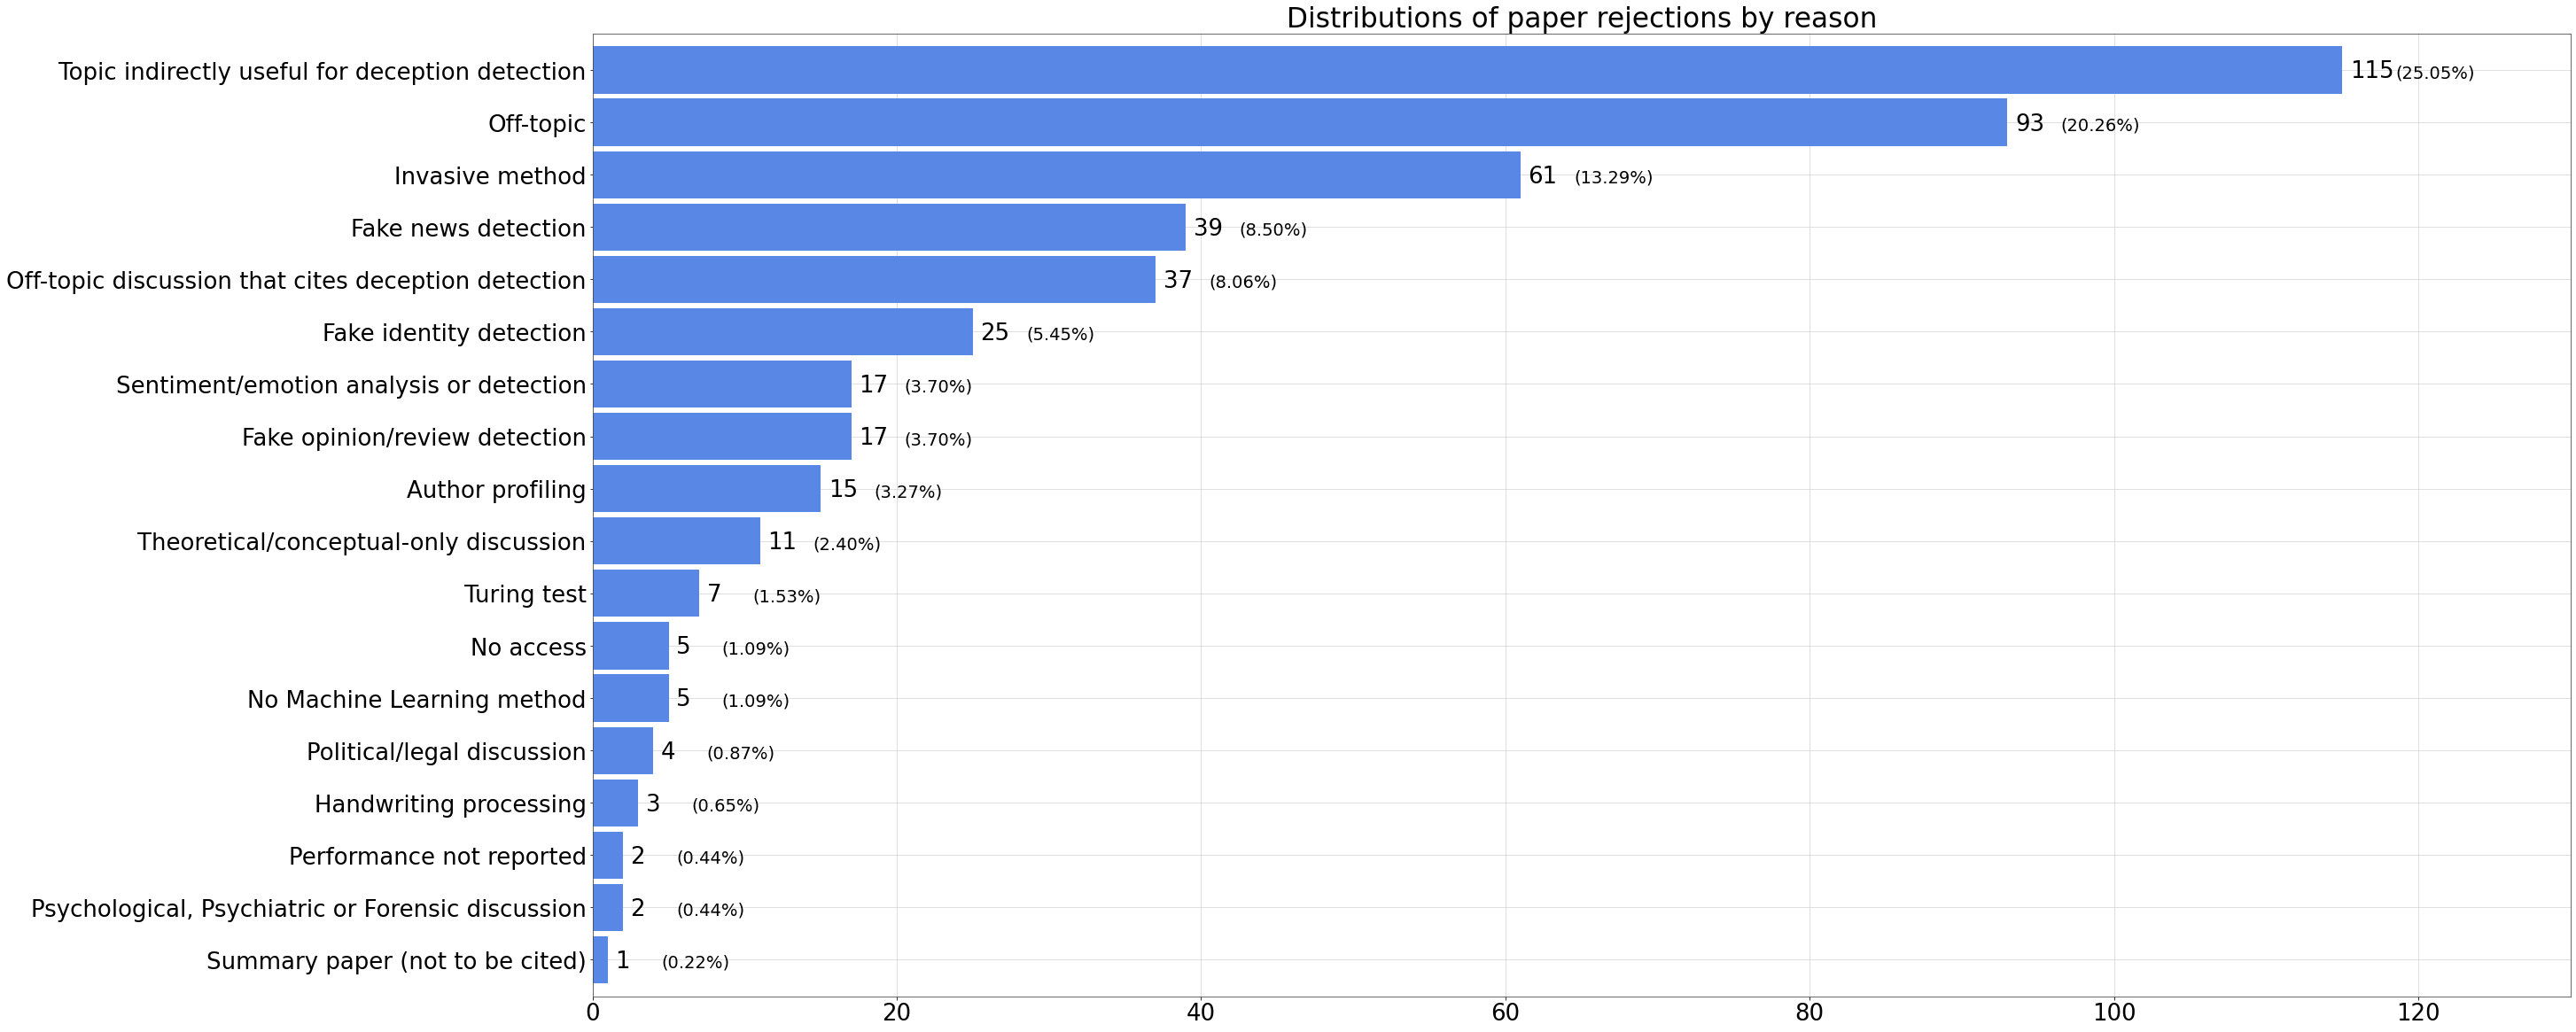

In [6]:
system_tags = catalog.state_tag_names
rejections_df = all_documents_df.loc[:,['tags', 'id']]
rejections_df['Reason'] = rejections_df.tags.apply(lambda tags: [tag for tag in tags if tag not in system_tags])
rejections_df['Reason'] = rejections_df.Reason.apply(lambda tags: tags[0] if len(tags)>0 else None)
rejections_df.dropna(inplace=True)
rejections_df = pd.DataFrame(rejections_df.loc[:,['id', 'Reason']])
rejections_df = rejections_df.groupby(['Reason']).agg(len)
rejections_df.columns = ['Papers']
rejections_df.sort_values('Papers', ascending=True, inplace=True)
#rejections_df

utility.barh(rejections_df, title='Distributions of paper rejections by reason',
             total=rejections_df.Papers.sum(), figsize=(40, 20), xlim=130, x_offset=0.5, x_offset_perc=3)

### Document rejection reasons after deep screening
Shallow screening produced a corpus that was then deep screened (139 documents). After the full text reading some of those (56 documents) were rejected because they
violated some of the selection criteria. Those are all listed below.

In [7]:
rejection_reasons_df = all_documents_df.loc[:,['tags', 'id']]
rejection_reasons_df['Status'] = rejection_reasons_df.tags.apply(utility.doc_status)
rejection_reasons_df = rejection_reasons_df[rejection_reasons_df.Status.isin(['Post-rejected (after deep screening)'])]
rejection_reasons_df['Year'] = rejection_reasons_df.id.apply(lambda id: document_by_id[id].year)
rejection_reasons_df['Title'] = rejection_reasons_df.id.apply(lambda id: document_by_id[id].title)
rejection_reasons_df['Authors'] = rejection_reasons_df.id.apply(lambda id: '; '.join([au.author.long_name for au in document_by_id[id].authors]))
rejection_reasons_df['Reason'] = rejection_reasons_df.tags.apply(lambda tags: list(set(tags) - set(['Rejected', 'Pre-selected'])) if 'Rejected' in tags else None)
rejection_reasons_df.dropna(inplace=True)
rejection_reasons_df['Reason'] = rejection_reasons_df.Reason.apply(lambda reason: reason[0])
rejection_reasons_df.drop(columns=['tags', 'Status'], inplace=True)
rejection_reasons_df.sort_values(by=['Year', 'Title'], ascending=False, inplace=True)
#rejection_reasons_df

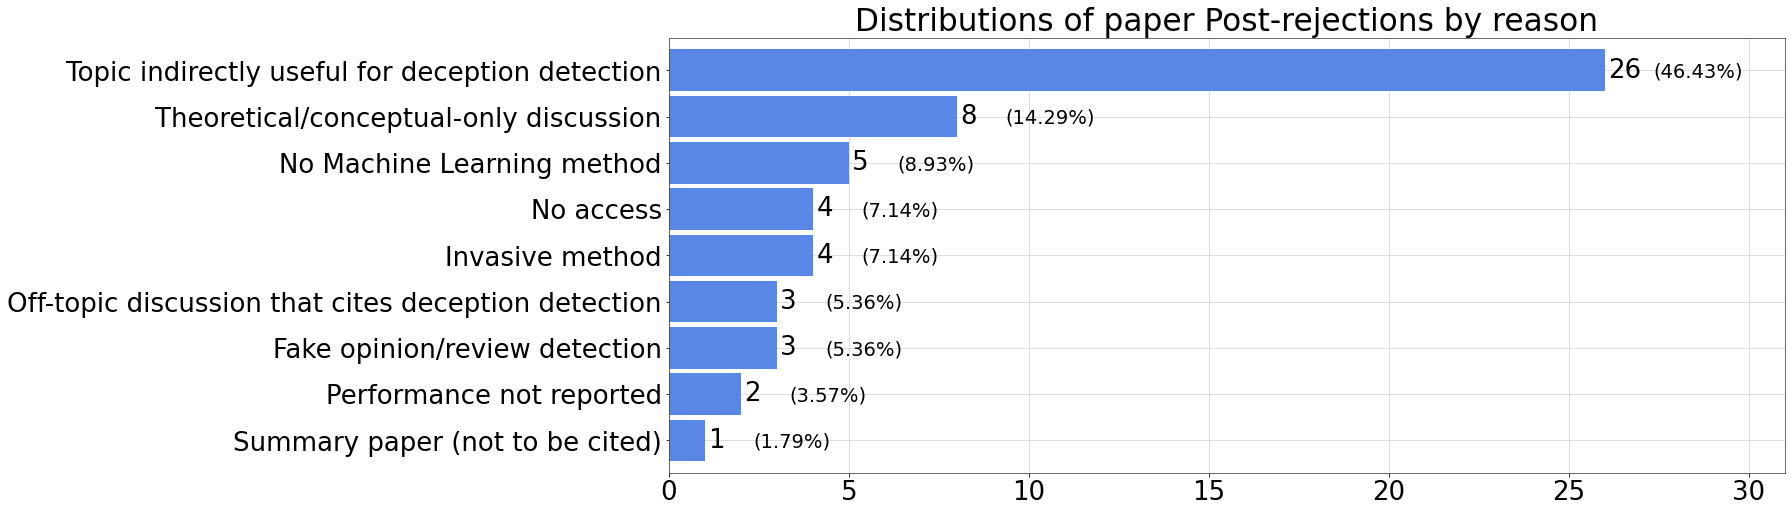

In [8]:
rejection_reasons_sum_df = pd.DataFrame(rejection_reasons_df.loc[:,['id', 'Reason']])
rejection_reasons_sum_df = rejection_reasons_sum_df.groupby(['Reason']).agg(len)
rejection_reasons_sum_df.columns = ['Papers']
rejection_reasons_sum_df.sort_values('Papers', ascending=True, inplace=True)
#rejections_df

utility.barh(rejection_reasons_sum_df, title='Distributions of paper Post-rejections by reason',
             total=rejection_reasons_sum_df.Papers.sum(), figsize=(20,8), xlim=31, x_offset_perc=1.25)

### Selected corpus analysis
From this point on all analysis will be made only on the corpus of those papers that satisfy the selection criteria of the review.

#### Selected Articles distribution per source database
Here we show the source distribution of the selected articles only. While ACM Digital Library returned a large number of potential articles, IEEE Xplore holds
the majority of the selected ones.

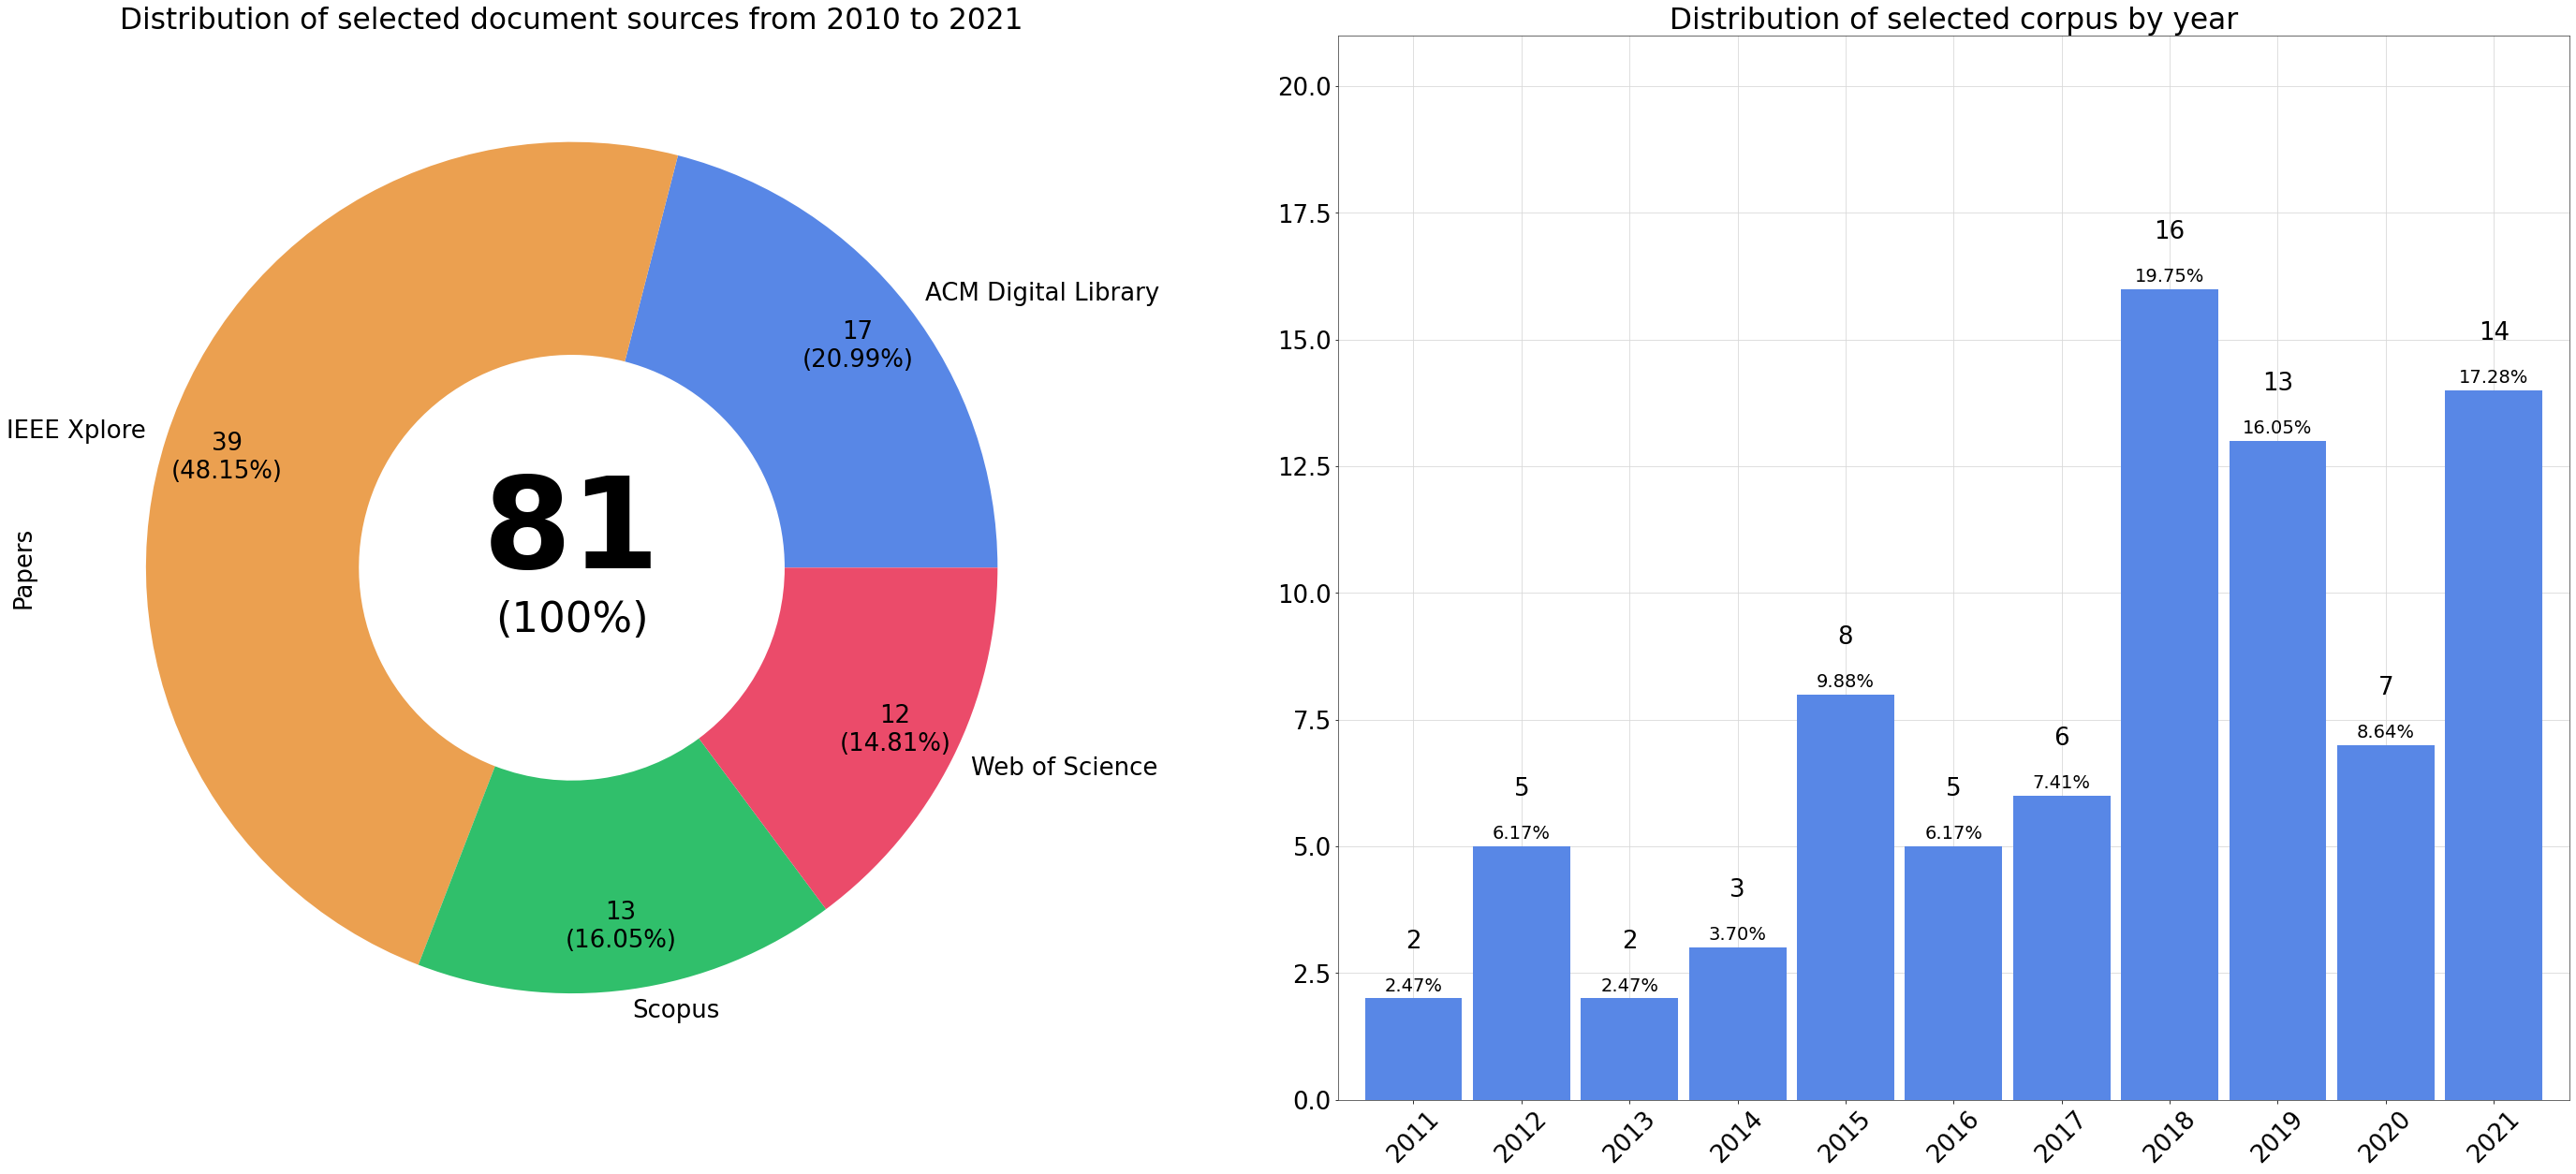

In [9]:
source_df = corpus_df.loc[:,['generator','doi']]
source_df = source_df.groupby(['generator']).agg(len)
source_df.columns = ['Papers']

fig, ax = plt.subplots(1, 2, figsize=(40, 18))
fig.set_tight_layout(0.01)

utility.donut(source_df, 'Distribution of selected document sources from 2010 to 2021', ax=ax[0])

docs_year_df = corpus_df.loc[:,['year','id']]
docs_year_df = docs_year_df.groupby(['year']).agg(len)
docs_year_df.columns = ['Volume']
utility.bar(docs_year_df, title=f'Distribution of selected corpus by year', total=docs_year_df['Volume'].sum(),
            ylim=21, ax=ax[1])
plt.show()

#### Papers per journal

In [10]:
temp_df = pd.DataFrame(corpus_df)
temp_df['Journal'] = temp_df.id.apply(lambda id: document_by_id[id].journal)

journals_df = temp_df.loc[:,['id', 'Journal']]
journals_df.columns = ['Volume', 'Journal']
journals_df = journals_df.groupby(['Journal']).agg(len)
journals_df.sort_values(['Volume', 'Journal'], ascending=[False, True], inplace=True)
journals_df

,Volume
Journal,
Proceedings of the Workshop on Computational Approaches to Deception Detection,3
2019 IEEE/CVF Conference on Computer Vision and Pattern Recognition Workshops (CVPRW),2
IEEE Access,2
IEEE Transactions on Information Forensics and Security,2
Proceedings of the 2015 ACM on International Conference on Multimodal Interaction,2
"15th Conference of the European Chapter of the Association for Computational Linguistics, EACL 2017 - Proceedings of the Student Research Workshop",1
"18TH ANNUAL CONFERENCE OF THE INTERNATIONAL SPEECH COMMUNICATION ASSOCIATION (INTERSPEECH 2017), VOLS 1-6: SITUATED INTERACTION",1
"19TH ANNUAL CONFERENCE OF THE INTERNATIONAL SPEECH COMMUNICATION ASSOCIATION (INTERSPEECH 2018), VOLS 1-6: SPEECH RESEARCH FOR EMERGING MARKETS IN MULTILINGUAL SOCIETIES",1
2013 IEEE 56th International Midwest Symposium on Circuits and Systems (MWSCAS),1


### Finnish!!!